# **Apple-Twitter-Sentiment-Analysis**

##  Project Introduction: Apple Twitter Sentiment Analysis

This project aims to classify sentiments in tweets mentioning **Apple Inc.** into three categories: **positive**, **neutral**, or **negative**. Sentiment analysis is a key application of natural language processing (NLP) that helps organizations understand public opinion at scale.

We use a labeled dataset of tweets annotated with sentiment categories and confidence scores. By building a machine learning model to classify these tweets automatically, we aim to enable scalable monitoring of public sentiment related to Apple’s brand and products.

This project follows the **CRISP-DM (Cross-Industry Standard Process for Data Mining)** methodology, which provides a structured and iterative framework for carrying out data science projects effectively.

---

##  Business Understanding

Understanding customer and public sentiment is crucial for brand management, competitive analysis, and decision-making. In this case, we are interested in automating the detection of sentiment in social media posts about **Apple Inc.**.

Manually labeling tweets is both time-consuming and prone to inconsistency. Automating this process allows:
- **Real-time insights** into how people perceive Apple products, services, and announcements.
- **Trend monitoring** around events such as product launches or controversies.
- **Actionable intelligence** for marketing, public relations, and strategic planning.

###  Objective

The main objectives of this project are:

- To preprocess the tweet data using **Natural Language Processing (NLP)** techniques.
- To perform **Exploratory Data Analysis (EDA)** on the text to understand word patterns, frequency, and sentiment distribution.
- To build a **machine learning classifier** that accurately predicts the sentiment of tweets.
- To evaluate the performance of different classifiers using appropriate **classification metrics** such as accuracy, precision, recall, and F1-score.


This system could later be extended for real-time social media tracking or integrated into customer feedback pipelines.

---

## Data Understanding

The dataset used in this project is the **Apple Twitter Sentiment DFE** dataset from data world. It contains tweets labeled with sentiment classes and additional metadata. Here's a high-level overview of the dataset:

###  Key Columns:
- `text`: The tweet content (our main feature for analysis).
- `sentiment`: The sentiment label assigned to each tweet (our target variable).
- `sentiment:confidence`: A score indicating how confident the annotator or system was in the assigned label.

###  Observations from Initial Exploration:
- The dataset contains **3886 rows** and several metadata columns (e.g., unit ID, query, annotation state) which are not relevant for sentiment modeling and will be dropped during preprocessing.
- The `sentiment` column contains some **non-numeric and noisy values** (e.g., `not_relevant`, or merged label codes like `3\n1`) that must be cleaned or filtered out.
- The `text` column contains **raw social media content**, including mentions, hashtags, links, and special characters that will need to be cleaned for modeling.
- The `sentiment:confidence` column varies in range and may be used to **filter out low-confidence annotations** to improve model quality.

This understanding will guide our **data cleaning and feature engineering** efforts in the next stages of the project.



In [3]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt_tab")
nltk.download("wordnet")
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# loading the dataset
df=pd.read_csv("Apple-Twitter-Sentiment-DFE.csv",encoding="ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL




We load the Apple Twitter Sentiment dataset from a CSV file using `pandas.read_csv`. Since the file contains special characters, we specify the encoding as `ISO-8859-1`.

The dataset contains various metadata columns related to tweet annotations as well as the actual tweet text and sentiment labels.


In [5]:
# extracting the relevant columns
df_rel=df[["sentiment","sentiment:confidence","text"]]
df_rel.head()

,sentiment,sentiment:confidence,text
0,3,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,1.0000,My cat only chews @apple cords. Such an #Apple...
3,3,0.5848,I agree with @jimcramer that the #IndividualIn...
4,3,0.6474,Nobody expects the Spanish Inquisition #AAPL


From the loaded dataset, we extract only the columns that are directly relevant for sentiment analysis:

- `sentiment`: the label or target variable
- `sentiment:confidence`: confidence score of the assigned label
- `text`: the actual tweet text we want to analyze

This step simplifies our dataset to only what's necessary for modeling and text preprocessing.


In [6]:
# renaming the sentiment:confidence column
df_rel=df_rel.rename(columns={"sentiment:confidence":"sentiment confidence"})


Here, we rename the column `sentiment:confidence` to `sentiment confidence` for easier access and improved readability in our analysis and model-building code.


In [7]:
# summary of the dataset
df_rel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3886 non-null   object 
 1   sentiment confidence  3886 non-null   float64
 2   text                  3886 non-null   object 
dtypes: float64(1), object(2)
memory usage: 91.2+ KB



In this step, we examine a concise summary of the dataset. It contains 3 columns and 3,886 entries. The `sentiment` and `sentiment confidence` columns are currently stored as object types, suggesting the need for further inspection and possible data type conversion before modeling.


In [8]:
col_check=["sentiment","sentiment confidence"]
for col in col_check:
    print(df_rel[col].value_counts())

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64
sentiment confidence
1.0000    1899
0.6722      46
0.6884      32
0.6825      29
0.6635      27
          ... 
0.8578       1
0.4882       1
0.6490       1
0.6686       1
0.9230       1
Name: count, Length: 654, dtype: int64


We inspect the value counts of two key columns:
- `sentiment`: to see how many tweets fall into each label category
- `sentiment confidence`: to examine the spread of confidence scores assigned during annotation

This step helps us identify possible anomalies like unexpected labels (e.g., `not_relevant`) and decide on thresholding for label quality based on confidence.


In [9]:
# casting 'sentiment' and 'sentiment confidence' column values to integers
df_rel["sentiment confidence"] = pd.to_numeric(df_rel["sentiment confidence"], errors='coerce')
df_rel["sentiment"] = pd.to_numeric(df_rel["sentiment"], errors='coerce')
df_rel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3804 non-null   float64
 1   sentiment confidence  3886 non-null   float64
 2   text                  3886 non-null   object 
dtypes: float64(2), object(1)
memory usage: 91.2+ KB




This cell ensures that the `sentiment` and `sentiment confidence` columns are properly converted to numeric values using `pd.to_numeric`.

We use `errors='coerce'` to handle invalid entries (e.g., text labels like `'not_relevant'`) by converting them to `NaN`.

After conversion, we call `.info()` again to verify the changes and identify any new missing values introduced during the coercion.


In [10]:
# creating a function to clean the dataset
def clean(df):
    print(f"null : {df.isna().sum()}")
    df=df.dropna()
    print(f"is duplicated : {df.duplicated().sum()}")
    df=df.drop_duplicates()
    return df
    

Here we define a reusable function called `clean(df)` to perform essential dataset cleaning:
- Display the number of missing values (`NaN`)
- Drop rows with missing values
- Display the number of duplicate rows
- Remove duplicate rows

The cleaned DataFrame is returned for further use in model development.


In [11]:
# utilizing the clean function
df_clean=clean(df_rel)
df_clean.info()

null : sentiment               82
sentiment confidence     0
text                     0
dtype: int64
is duplicated : 382
<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment             3422 non-null   float64
 1   sentiment confidence  3422 non-null   float64
 2   text                  3422 non-null   object 
dtypes: float64(2), object(1)
memory usage: 106.9+ KB


## text preprocessing

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

- Lower Casing: Each text is converted to lowercase.
- Replacing URLs: Links starting with "http" or "https" or "www" are replaced by space.
- Replacing Usernames: Replace @Usernames with space
- Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
- Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- Removing Short Words: Words with length less than 2 are removed.
- Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
- Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [12]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

def preprocess_tweets(series):
    wordLemm = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    def clean_tweet(tweet):
        tweet = str(tweet).lower()
        tweet = re.sub(urlPattern, ' ', tweet)
        tweet = re.sub(userPattern, ' ', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        words = []
        for word in tweet.split():
            if word not in stop_words and len(word) > 1:
                word = wordLemm.lemmatize(word)
                words.append(word)
        return " ".join(words)

    return series.apply(clean_tweet)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df_clean['processed'] = preprocess_tweets(df_clean['text'])  # or whatever column contains your raw tweets

In [14]:
df_clean

,sentiment,sentiment confidence,text,processed
0,3.0,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,aapl best steve job email ever
1,3.0,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,rt aapl stock mini flash crash today aapl aapl
2,3.0,1.0000,My cat only chews @apple cords. Such an #Apple...,cat chew cord applesnob
3,3.0,0.5848,I agree with @jimcramer that the #IndividualIn...,agree individualinvestor trade apple aapl exte...
4,3.0,0.6474,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition aapl
...,...,...,...,...
3881,3.0,0.7757,(Via FC) Apple Is Warming Up To Social Media -...,via fc apple warming social medium apple hirin...
3882,3.0,0.6225,RT @MMLXIV: there is no avocado emoji may I as...,rt avocado emoji may ask
3883,5.0,0.9347,@marcbulandr I could not agree more. Between @...,could agree great thing happen appleandibm ibm...
3884,1.0,0.9230,My iPhone 5's photos are no longer downloading...,iphone photo longer downloading automatically ...


## Exploratory Data Analysis

To improve clarity and interpretability, we rename the values in the **sentiment** column. This makes the labels more descriptive and easier to understand during analysis and visualization.


In [15]:
# renaming the sentiment column values
df_clean["sentiment"]=df_clean["sentiment"].replace({1.0:"Negative",3.0:"Neutral",5.0:"positive"})

### checking for the spread of sentiments


To understand the distribution of our target classes, we plot a count plot. This visualization helps us identify any class imbalances that may exist in the dataset.


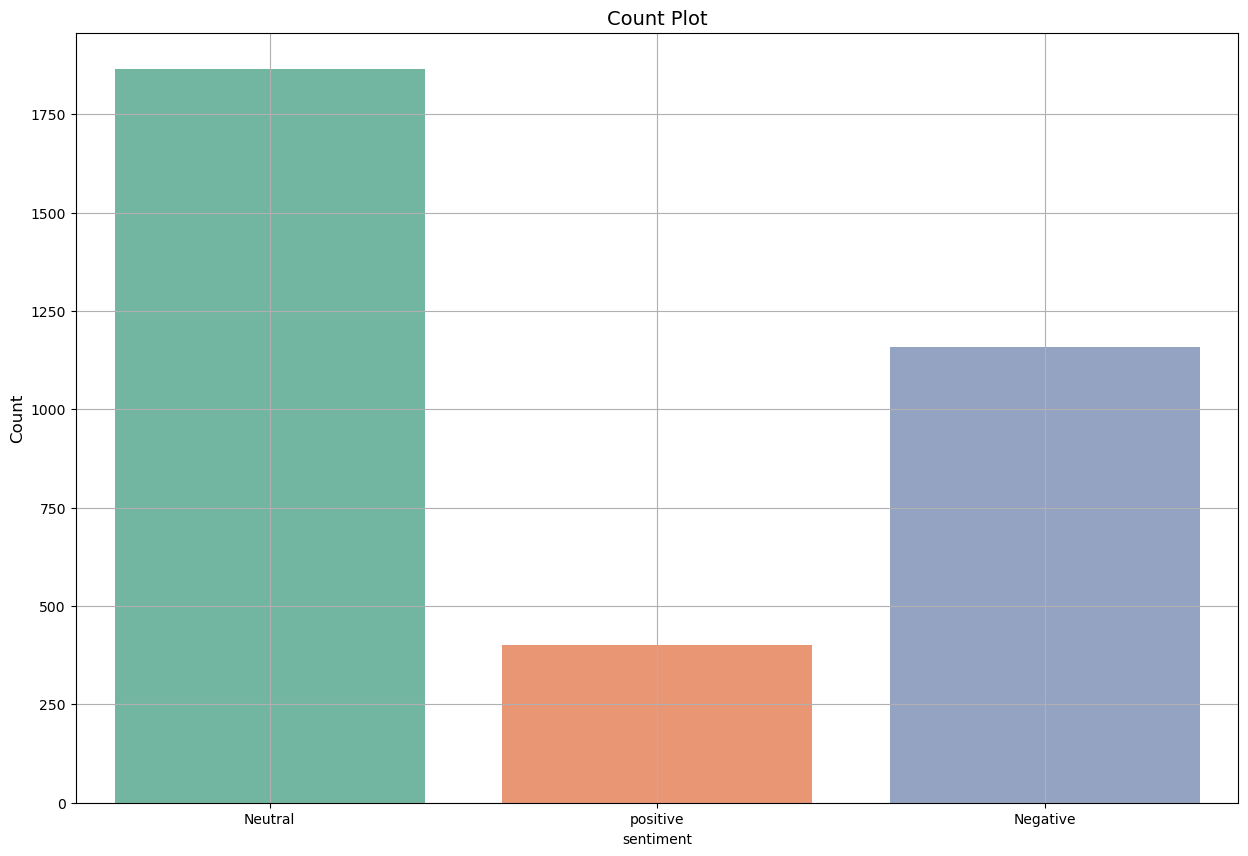

In [16]:
# importing Plot class
from kev_plot import Plot
# initializing the class
plot=Plot()
plot.countplot(data=df_clean,x="sentiment")

The count plot illustrates the distribution of tweets across three sentiment categories: neutral, positive, and negative. From the chart, it is evident that neutral tweets are the most frequent, significantly outnumbering the other two classes. Negative tweets follow, indicating that a considerable portion of the tweets express dissatisfaction or criticism. On the other hand, positive tweets are the least represented in the dataset.

This imbalance in the sentiment classes suggests that the dataset is not evenly distributed, which could have implications for any machine learning models trained on this data. For example, models might become biased toward predicting the majority class (neutral sentiment) unless appropriate measures—such as class weighting or resampling—are taken during preprocessing.

Understanding this distribution is an important first step in preparing the data for analysis, as it highlights the need for careful handling of class imbalance to ensure accurate and fair predictions across all sentiment categories.

### Feature Engineering

To enhance our understanding of the dataset, we create additional columns that capture the number of characters, sentences, and words in each text entry. These new features will allow us to explore the structural properties of the text and may provide useful signals for downstream analysis or modeling.

In [17]:
# creating columns for number of characters, number of sentences and number of words
df_clean["char"]=df_clean["text"].apply(lambda x:len(x))
df_clean["words"]=df_clean["text"].apply(lambda x:nltk.word_tokenize(x)).apply(lambda x:len(x))
df_clean["sentences"]=df_clean["text"].apply(lambda x:nltk.sent_tokenize(x)).apply(lambda x:len(x))
df_clean.sample(10)

,sentiment,sentiment confidence,text,processed,char,words,sentences
723,Negative,1.0000,I'm going to press the play button!! Wait no I...,going press play button wait fix apps,99,25,2
3502,Neutral,1.0000,RT @abdinsyakirin: '@apple : Hey you wanna use...,rt hey wanna use ifon siks jas follow get,103,27,2
2773,Neutral,1.0000,Apple Debuts New iPad Air 2 TV Ad 'Change' wit...,apple debut new ipad air tv ad change new webs...,96,19,1
1256,Negative,1.0000,@apple you are loosing all the things that use...,loosing thing used make much better live window,100,21,1
3,Neutral,0.5848,I agree with @jimcramer that the #IndividualIn...,agree individualinvestor trade apple aapl exte...,136,29,1
604,Neutral,0.3374,Product Hunters: The Functional (And Whimsical...,product hunter functional whimsical keyboard i...,105,20,1
3054,Neutral,0.7039,#AAPL:How to get an unsubsidized smartphone fo...,aapl get unsubsidized smartphone,76,16,1
750,Neutral,0.6691,#Apple's Recent Pullback A Buy Opportunity #AA...,apple recent pullback buy opportunity aapl,71,13,1
2848,Neutral,1.0000,RT @cl4yt0n_c00p3r: There needs to be a Texas ...,rt need texas flag emoji,63,14,1
3839,positive,0.3555,@afrobugeisha @Apple you lol,lol,28,6,1


### Data Description

In [18]:
df_clean.describe()

,sentiment confidence,char,words,sentences
count,3422.000000,3422.000000,3422.000000,3422.000000
mean,0.831134,99.542665,20.823787,1.598480
std,0.175389,32.461059,7.230791,0.838337
min,0.332700,11.000000,3.000000,1.000000
25%,0.674925,77.000000,16.000000,1.000000
50%,0.853900,102.000000,21.000000,1.000000
75%,1.000000,130.000000,27.000000,2.000000
max,1.000000,148.000000,40.000000,7.000000


he table above presents summary statistics for four key columns: **sentiment confidence**, **char**, **words**, and **sentences** — calculated from 3,422 tweets after cleaning.

- **Sentiment Confidence**: This column represents the model’s confidence in assigning sentiment labels. The mean confidence score is approximately **0.83**, with a minimum of **0.33** and a maximum of **1.00**. The high median (0.85) and 75th percentile (1.00) suggest that most predictions were made with strong confidence. However, the standard deviation of **0.17** indicates some variability in certainty, likely due to ambiguous or neutral tweets.

- **Char (Characters)**: On average, tweets contain **about 100 characters**, with lengths ranging from **11** to **148** characters. The spread (std ≈ 32.46) suggests a moderate variation in tweet length, consistent with Twitter's character limits and user writing styles.

- **Words**: Each tweet has an average of **21 words**, with a minimum of **3** and a maximum of **40**. The median word count is **21**, closely aligning with the mean, indicating a fairly symmetric distribution. Most tweets fall between **16 (25%) and 27 (75%)** words, with relatively few very short or very long entries.

- **Sentences**: Most tweets are concise, with an average of **1.6 sentences**. The data shows that 50% of tweets contain only **1 sentence**, and 75% contain no more than **2 sentences**. The maximum is **7**, which likely reflects a few unusually long or punctuated tweets. The small standard deviation (**0.83**) confirms that sentence count is generally low and consistent.

Overall, these statistics confirm that the dataset contains **compact, mostly single-sentence tweets**, with **high sentiment confidence scores** and consistent length in terms of characters and words. This provides a solid foundation for further Natural Language Processing (NLP) tasks like classification or visualization.

### box plot of the distribution of number of characters|words|sentences accross classes

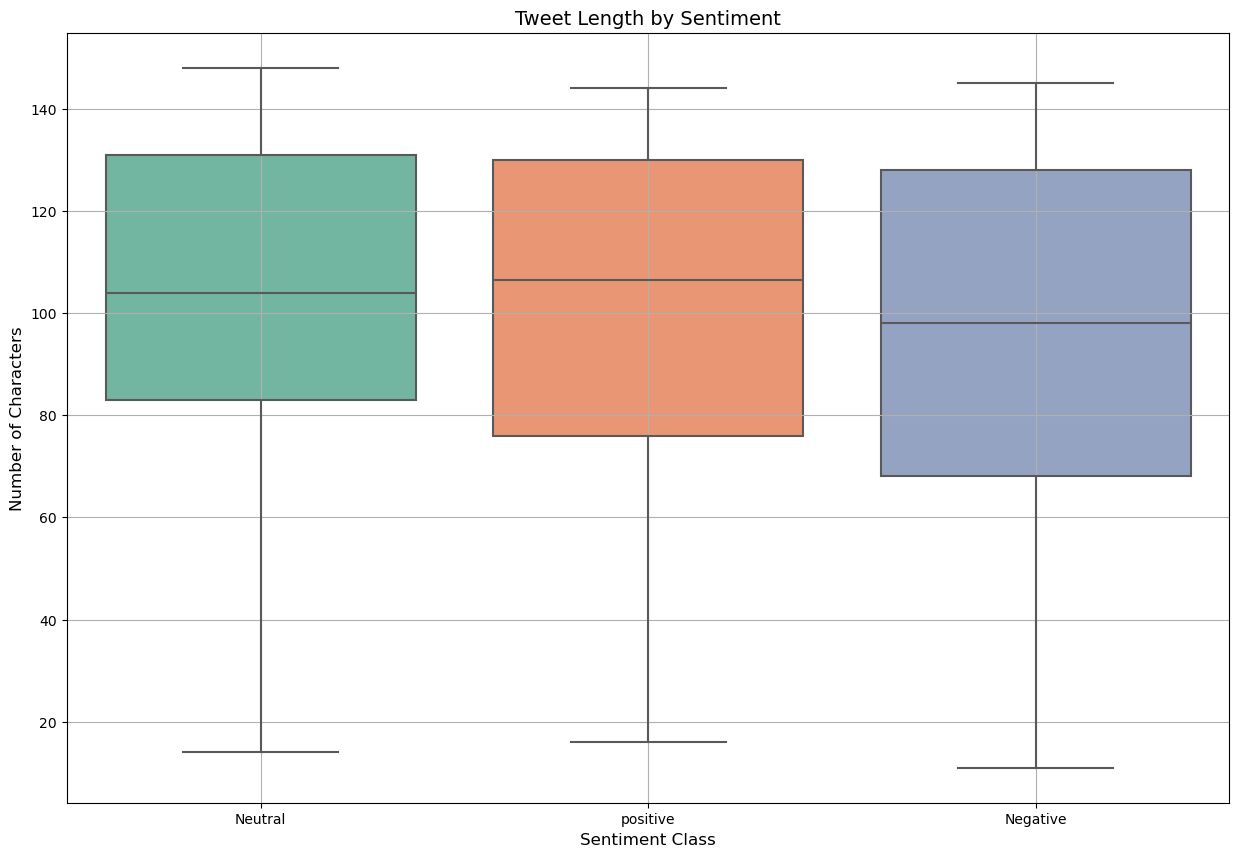

In [19]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='char',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of Characters')

The boxplot illustrates how tweet lengths, measured by the number of characters, are distributed across three sentiment categories: Neutral, Positive, and Negative.

Across all three classes, the median tweet length is relatively similar, though positive tweets appear to be slightly longer on average. The interquartile range (IQR)—which shows the middle 50% of tweet lengths—is broader for neutral and positive tweets, indicating greater variability in how long those tweets tend to be. In contrast, negative tweets show a slightly narrower range, suggesting more consistency in their length.

There are also outliers present in all three sentiment categories. These represent tweets that are either very short or unusually long, possibly reflecting highly condensed messages or those that approach the character limit of the platform.

In general, neutral and positive tweets tend to be longer than negative ones, though the overall character count range is similar across all sentiments. This distribution is valuable when exploring how sentiment correlates with tweet length and can serve as a useful feature during text preprocessing or model development for sentiment classification.

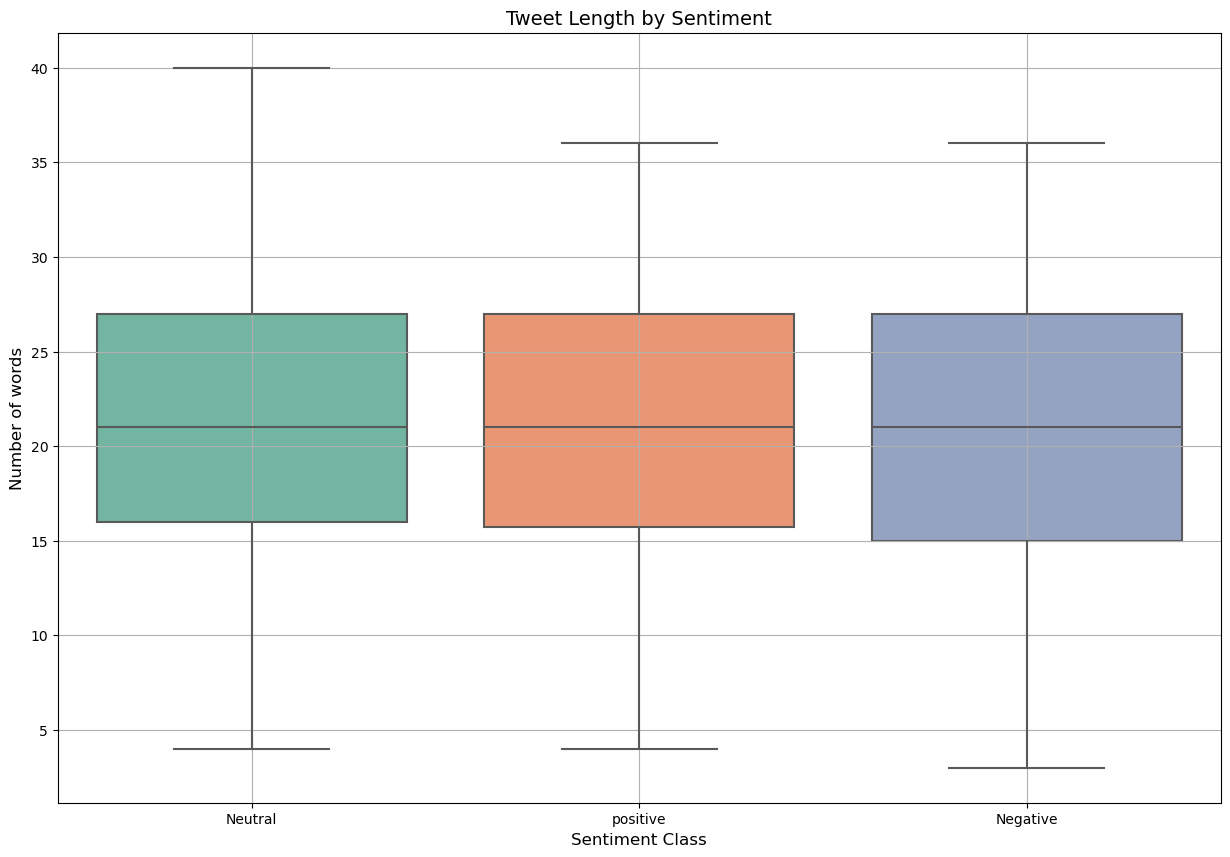

In [20]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='words',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of words')

The boxplot shows how tweet lengths, measured by the number of words, are distributed across the three sentiment categories: Neutral, Positive, and Negative.

Across all sentiment classes, the median word count is consistent, averaging around 21 words per tweet. This suggests that, regardless of the emotional tone, users tend to express their thoughts using a similar number of words. The interquartile range (IQR)—which represents the middle 50% of tweets—falls between 15 and 27 words for each sentiment, indicating a comparable spread in word usage.

While most tweets cluster within this range, there are a few outliers in each class. Some tweets are as short as 3 words, while others reach up to 40 words, reflecting occasional extremes in tweet length. However, these are exceptions rather than the norm.

Overall, the distribution of word counts is highly uniform across neutral, positive, and negative tweets. This implies that although the content or tone of a message may change with sentiment, the amount of words used does not vary significantly. This finding can be useful in natural language processing tasks, especially during text preprocessing or normalization, where consistent word length helps simplify modeling and analysis.

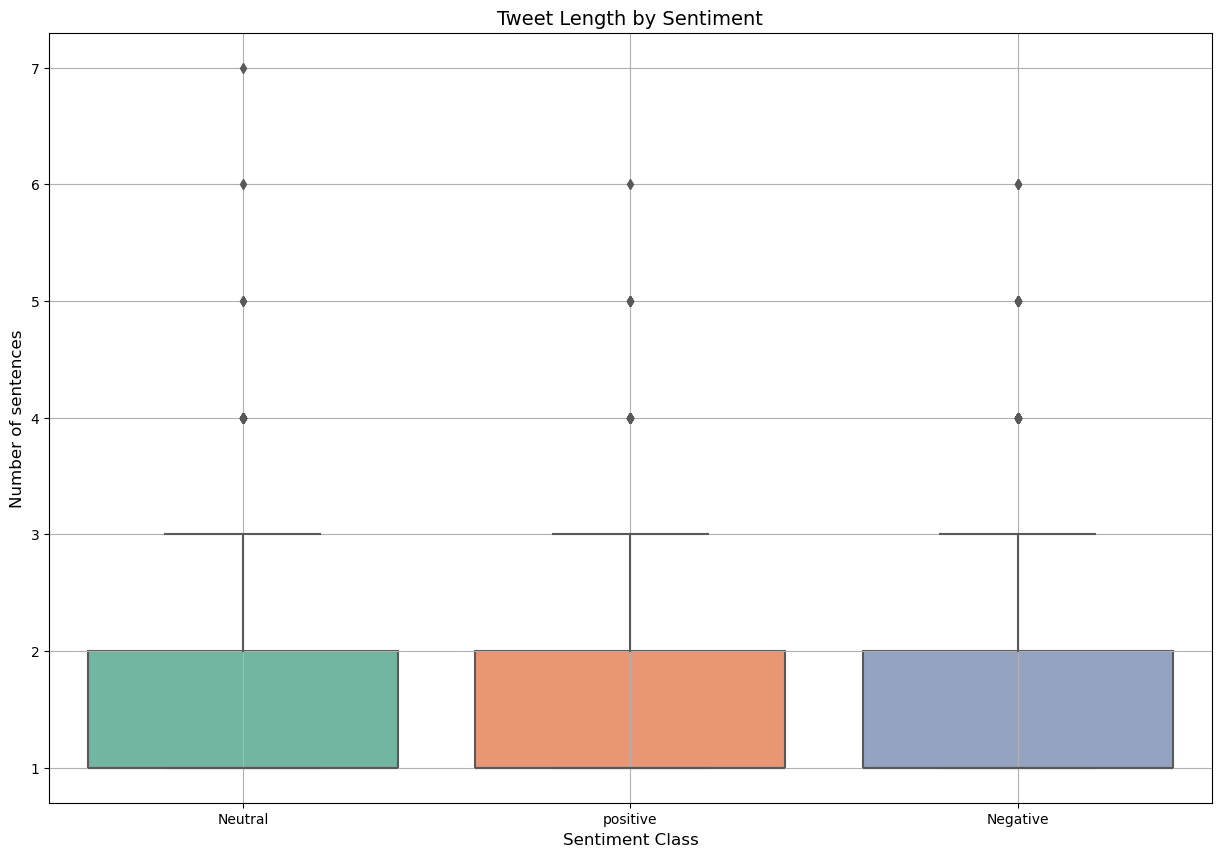

In [21]:
plot.boxplot(
    data=df_clean,
    x='sentiment',                # Categorical variable on the x-axis
    y='sentences',              # Numeric variable to plot
    title='Tweet Length by Sentiment',
    xlabel='Sentiment Class',
    ylabel='Number of sentences')

The boxplot illustrates the distribution of tweet lengths, measured by the number of sentences, across three sentiment categories: Neutral, Positive, and Negative.

Across all sentiment types, tweet lengths are remarkably consistent. The vast majority of tweets contain just one or two sentences, indicating a strong preference for brevity regardless of emotional tone. The median length is one sentence for all sentiment categories, further reinforcing the idea that tweets are typically short and concise.

While most tweets are brief, there are a few exceptions. Some tweets extend to six or seven sentences, appearing as outliers in the data. These longer entries may reflect more detailed messages, discussions, or storytelling, though they are relatively rare.

Overall, the distribution shows no significant variation in sentence length between the different sentiment classes. This suggests that the number of sentences used in a tweet does not depend on whether its tone is neutral, positive, or negative. The findings emphasize the inherently compact nature of tweets, which generally maintain a consistent structure across emotional expressions.

## Bar plot of top words per class

We need to **plot the top words for each class** to better understand the nature and distribution of words within each category. This will help us identify patterns or dominant terms that may influence classification.

In [22]:
# defining the plot funtion
from collections import Counter
def plot_top_words_by_sentiment(df, text_col='lemmas', sentiment_col='sentiment', top_n=10, figsize=(15, 10)):
    """
    Plots bar charts of the top N most common words for each sentiment class.

    Parameters:
    - df: DataFrame containing the text and sentiment
    - text_col: name of the column containing cleaned text
    - sentiment_col: name of the column containing sentiment labels
    - top_n: number of top words to show per sentiment
    - figsize: figure size for each subplot
    """
    sentiments = df[sentiment_col].unique()
    n_classes = len(sentiments)

    fig, axes = plt.subplots(1, n_classes, figsize=figsize)

    if n_classes == 1:
        axes = [axes]  # make axes iterable

    for ax, sentiment in zip(axes, sentiments):
        # Filter by sentiment
        texts = df[df[sentiment_col] == sentiment][text_col]
        all_words = " ".join(texts).split()
        
        # Count words
        word_counts = Counter(all_words).most_common(top_n)
        words, counts = zip(*word_counts)

        # Plot
        ax.barh(words[::-1], counts[::-1], color='skyblue')
        ax.set_title(f"Top {top_n} Words\n({sentiment})", fontsize=14)
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

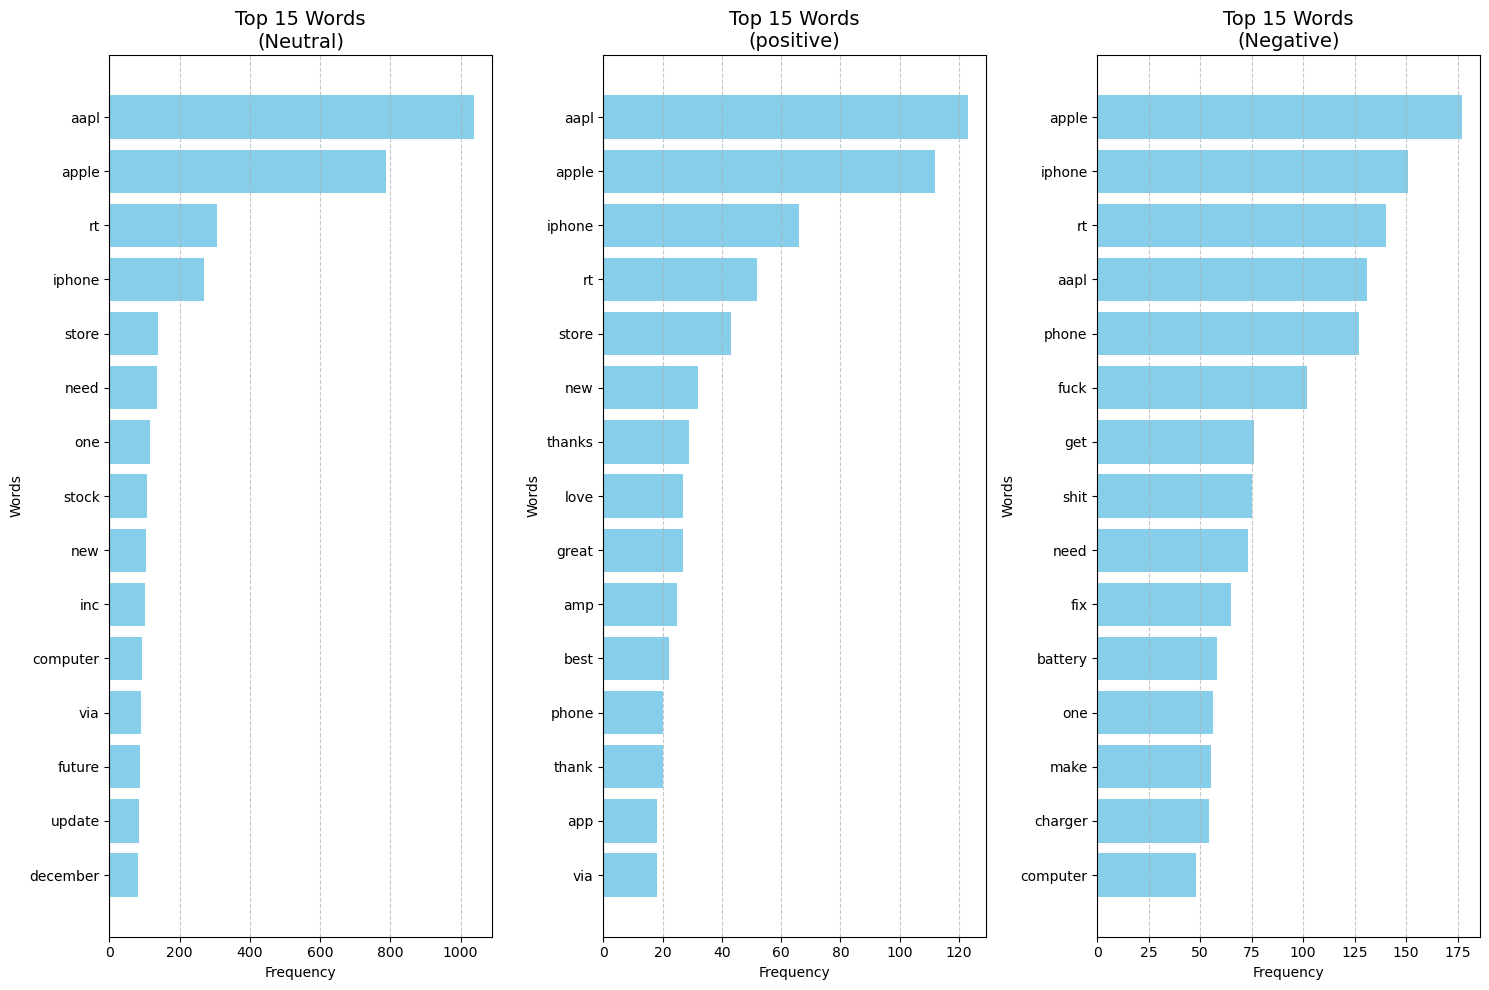

In [23]:
# calling the plot function
plot_top_words_by_sentiment(df_clean, text_col="processed", sentiment_col='sentiment', top_n=15)

From the plot, we observe that the top words in each class are the same. This indicates the presence of **custom (repeated or non-informative)** words across the classes, which may not contribute meaningfully to the classification task.

We will proceed to **drop the custom words** to improve the quality of our features.

In [24]:
# defining function to remove custom words
custom_stopwords = {'apple', 'aapl', 'rt', 'iphone'}

def remove_custom_words(text):
    tokens = text.split()  # turn string into list of words
    filtered = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered)  # return cleaned string

In [25]:
# removing custom words 
df_clean['lemmas_filtered'] = df_clean['processed'].apply(remove_custom_words)
df_clean.sample(5)

,sentiment,sentiment confidence,text,processed,char,words,sentences,lemmas_filtered
3310,positive,0.3467,RT @TeamCavuto: Protesters stage #DieIn protes...,rt protester stage diein protest store nyc ang...,134,31,2,protester stage diein protest store nyc anger ...
2247,Negative,0.6760,morning or should I say evening now that @appl...,morning say evening replaced crimped cord,96,18,2,morning say evening replaced crimped cord
3486,Neutral,1.0000,RT @smartoutsource1: Steve Wozniak calls @Appl...,rt steve wozniak call legendary garage bit myth,107,22,1,steve wozniak call legendary garage bit myth
2902,positive,1.0000,Photo: Yaaass. Shoutout to @apple.holidays and...,photo yaass shoutout amazing iphone stevejobs,124,24,3,photo yaass shoutout amazing stevejobs
409,Neutral,0.6172,CNBCTV: Day 1: #Apple's antitrust trial #aapl...,cnbctv day apple antitrust trial aapl,69,15,1,cnbctv day antitrust trial


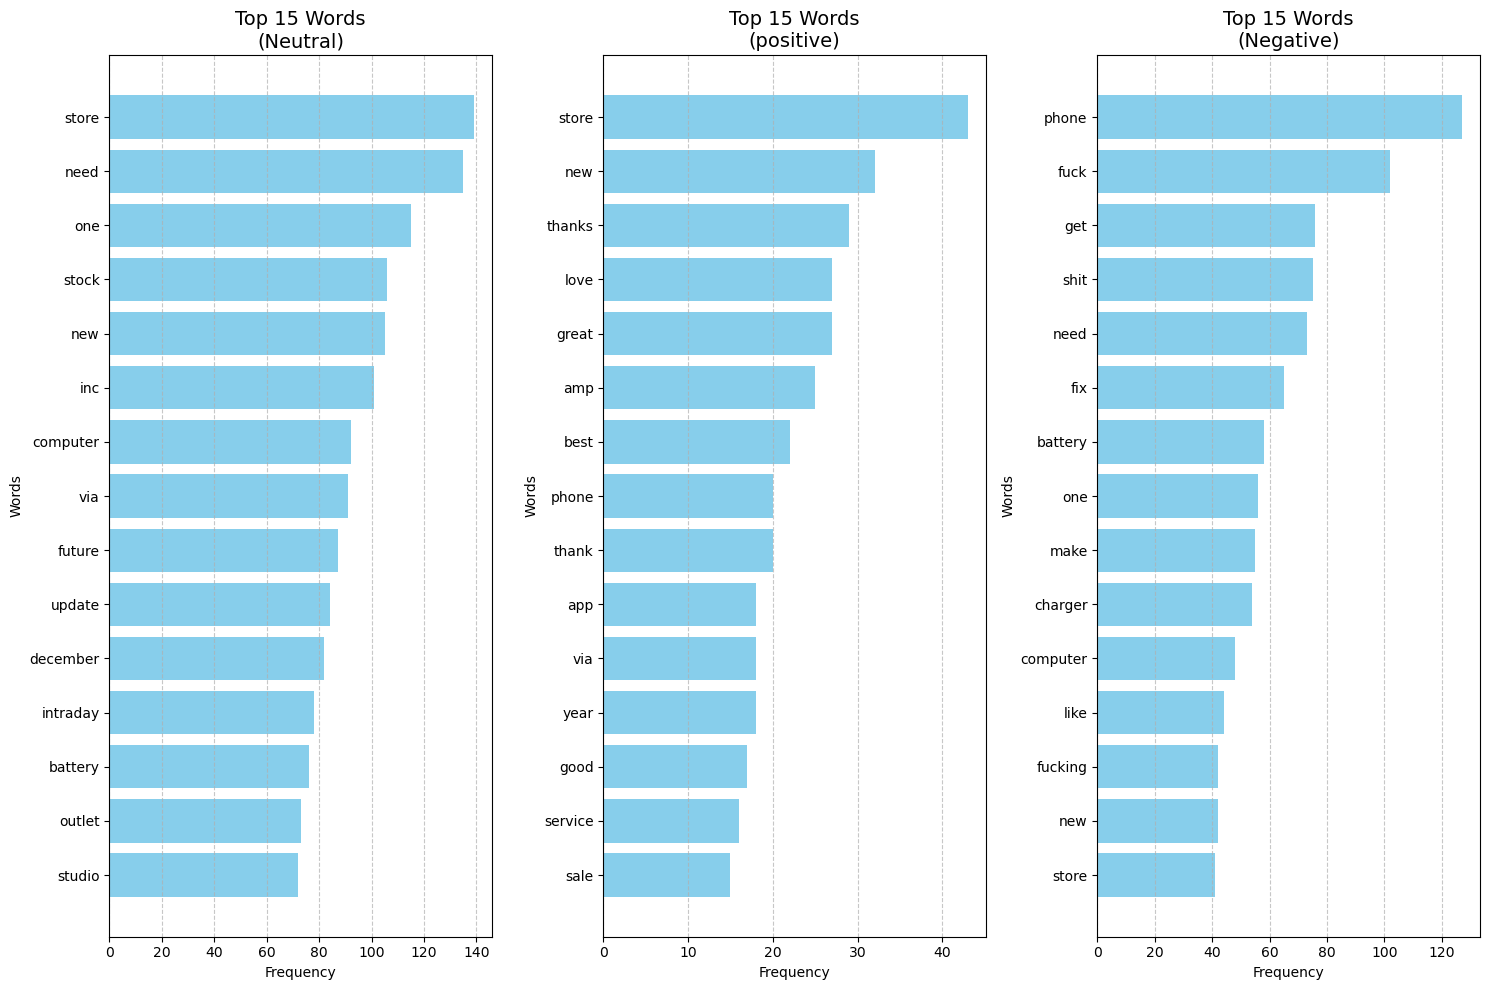

In [26]:
# ploting the new distribution of words without custom words
plot_top_words_by_sentiment(df_clean, text_col="lemmas_filtered", sentiment_col='sentiment', top_n=15)

The chart presents the top 15 most frequent words used in tweets, categorized by sentiment—neutral, positive, and negative. Each sentiment group reveals distinct word usage patterns that reflect the tone and context of the tweets.

In neutral tweets, the most common words include “store”, “need”, “one”, and “stock”, suggesting a focus on general information, product mentions, or factual statements. Words like “update”, “computer”, and “future” imply that these tweets often contain news, product availability, or technology-related content, with a neutral tone devoid of strong emotional expression.

Positive tweets are characterized by words that express gratitude, appreciation, or excitement. Common words such as “thanks”, “love”, “great”, “best”, and “thank” clearly reflect this sentiment. Even when the same terms appear across categories (like “store” or “new”), their context in positive tweets often involves favorable experiences or satisfaction with products or services.

In contrast, negative tweets contain more emotionally charged and explicit language. Words like “fuck”, “shit”, “fix”, and “fucking” signal frustration or dissatisfaction. The presence of terms such as “phone”, “battery”, “charger”, and “computer” indicates that technical issues or product failures are common topics of complaint. While some neutral and positive terms like “need”, “store”, and “new” appear in the negative category as well, their surrounding context likely shifts their sentiment based on user dissatisfaction.

Overall, this word frequency analysis reveals how language patterns differ significantly depending on sentiment. Positive tweets focus on appreciation, negative tweets highlight issues and frustrations, and neutral tweets are more descriptive and factual in nature.

## **Wordcloud Plot of Sentiment classes**

A word cloud helps visualize the most frequently occurring words in the text data. By representing word frequency through size, it provides a quick, intuitive overview of dominant themes or expressions in each sentiment category. This can uncover patterns that guide further text preprocessing or feature engineering.


In [27]:
# ! pip install wordcloud

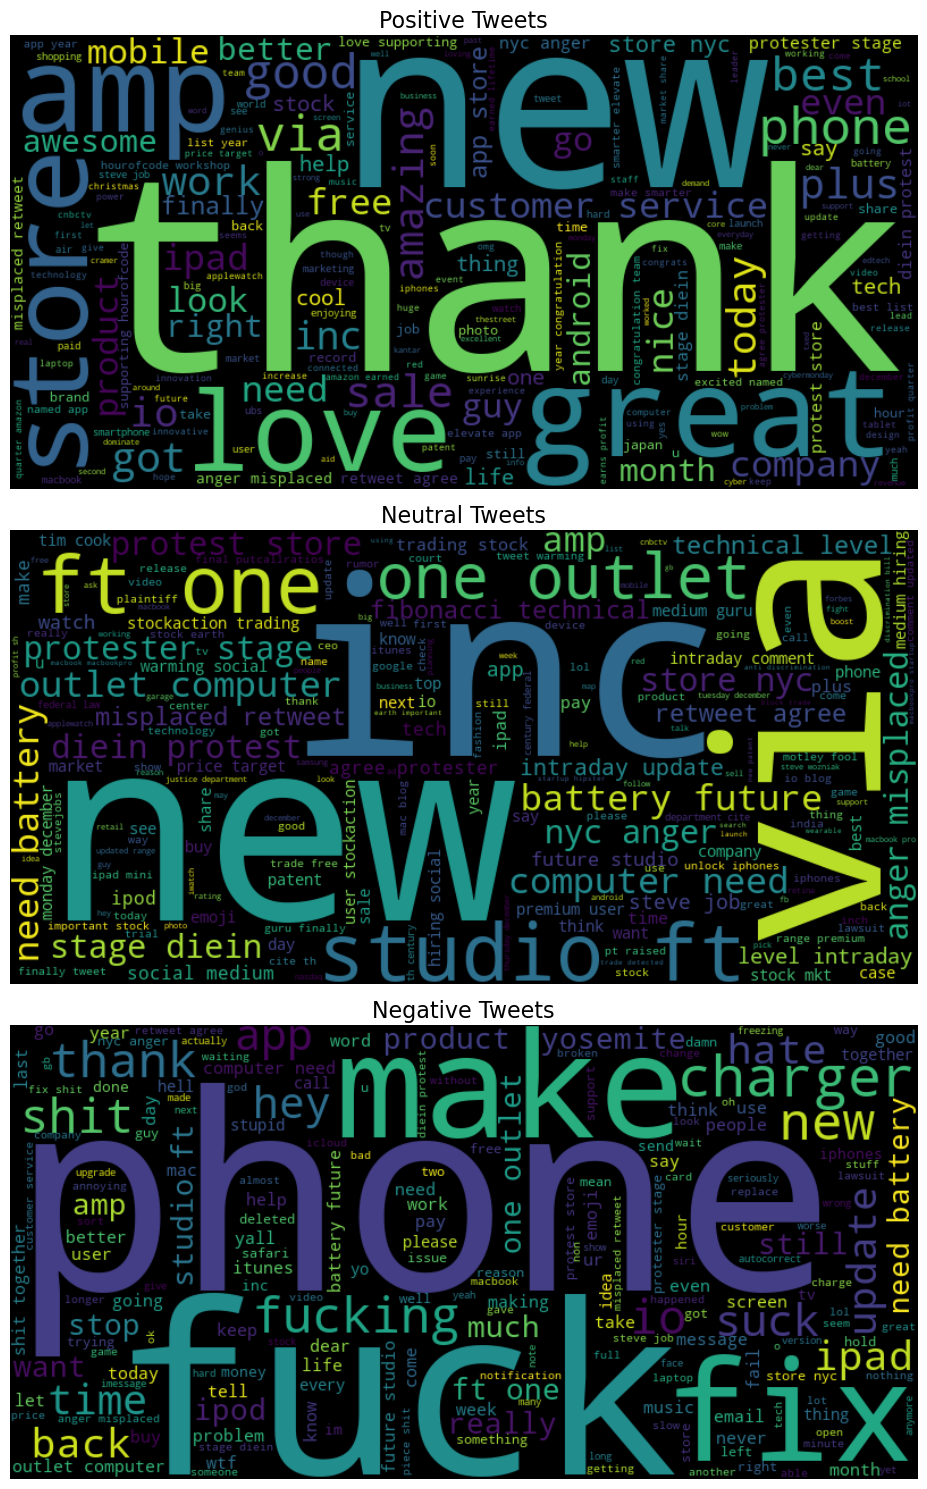

In [ ]:
from wordcloud import WordCloud

# List of sentiment classes (ensure they match the values in your DataFrame exactly)
sentiments = ['positive', 'neutral', 'negative']

# Set figure size for vertical layout
plt.figure(figsize=(10, 15))

# Generate and plot word cloud for each sentiment
for i, sentiment in enumerate(sentiments, 1):
    text = " ".join(
        df_clean[df_clean['sentiment'].str.lower() == sentiment]['lemmas_filtered'].astype(str)
    )

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='viridis',
        max_words=200
    ).generate(text)

    # Plot in a separate row
    plt.subplot(3, 1, i)  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"{sentiment.capitalize()} Tweets", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


To complement the earlier bar plots, we present word clouds for each sentiment category. While the bar plots showed the top terms by frequency, the word clouds offer a more intuitive and visually engaging representation of the dominant language used in tweets.

The visual prominence of words like **"thank"**, **"new"**, **"love"** in positive tweets, and strong language such as **"fuck"**, **"fix"**, and **"shit"** in negative tweets aligns with the patterns observed earlier. However, the word cloud adds value by making these patterns immediately recognizable through relative word sizes.

This visual helps reinforce our earlier observations and offers a quicker grasp of key language characteristics across sentiments.
